## Binary classification with Logistic regression 

### import libraries 

In [ ]:
from sqlalchemy import create_engine 
import pymysql 
import getpass #hidden password
password= getpass.getpass()

In [2]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np 

### connection to sql 

In [3]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)

In [4]:
df= pd.read_sql_query('''select t.type, t.operation, t.amount as t_amount, t.balance, t.k_symbol, l.amount as l_amount, l.duration, l.payments, l.status from trans t
left join loan l
on t.account_id = l.account_id
where l.status in ('A', 'B')''', engine)


In [5]:
df.head()

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status
0,PRIJEM,PREVOD Z UCTU,44749.0,45549.0,,79608,24,3317.0,A
1,PRIJEM,VKLAD,1000.0,1000.0,,52788,12,4399.0,A
2,PRIJEM,VKLAD,1100.0,1100.0,,21924,36,609.0,A
3,PRIJEM,VKLAD,700.0,700.0,,23052,12,1921.0,A
4,PRIJEM,VKLAD,900.0,900.0,,41904,12,3492.0,A


### EDA - exploratory data analysis - get to know the data 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74364 entries, 0 to 74363
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   type       74364 non-null  object 
 1   operation  74364 non-null  object 
 2   t_amount   74364 non-null  float64
 3   balance    74364 non-null  float64
 4   k_symbol   74364 non-null  object 
 5   l_amount   74364 non-null  int64  
 6   duration   74364 non-null  int64  
 7   payments   74364 non-null  float64
 8   status     74364 non-null  object 
dtypes: float64(3), int64(2), object(4)
memory usage: 5.1+ MB


In [7]:
# i want to see the means etc 
df.describe()

,t_amount,balance,l_amount,duration,payments
count,74364.000000,74364.000000,74364.000000,74364.000000,74364.000000
mean,7832.649125,46022.153061,102745.132645,23.942230,4356.580832
std,11729.040391,25439.948570,74749.275498,12.155783,2205.840892
min,0.000000,-14137.200000,4980.000000,12.000000,319.000000
25%,144.300000,27675.125000,46320.000000,12.000000,2569.000000
50%,3000.000000,40965.150000,86184.000000,24.000000,4051.000000
75%,9868.500000,60098.550000,140400.000000,36.000000,6315.000000
max,87300.000000,193910.000000,464520.000000,60.000000,9736.000000


In [9]:
# i want to understand the data types 
df.dtypes

type          object
operation     object
t_amount     float64
balance      float64
k_symbol      object
l_amount       int64
duration       int64
payments     float64
status        object
dtype: object

In [11]:
df.shape

(74364, 9)

In [ ]:
# clean /wrangling steps :
# change duration to object type / categorical - 12,24,36,48,72  
#k symbol includes ' ' white spaces - deal with those (and operation)
# drop any columns ? if columns are same, have too many nulls, dont add anything  -- iterative


#histograms or boxplots
# split the data into num and cat --- > diff options cleaning / scaling 

# check for multicollinearity 


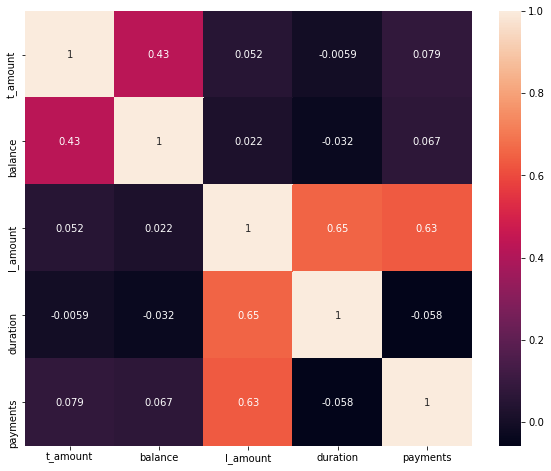

In [12]:
# check for multicollinearity 
corr_matrix=df.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

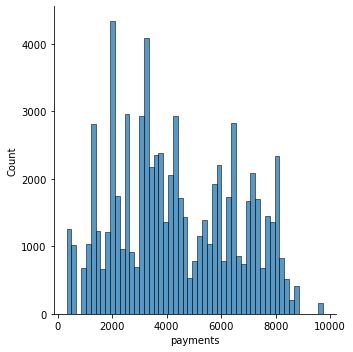

In [14]:
sns.displot(df['payments'])
plt.show()

Frequency analysis of column:  type
Frequency analysis of column:  operation
Frequency analysis of column:  k_symbol
Frequency analysis of column:  duration
Frequency analysis of column:  status


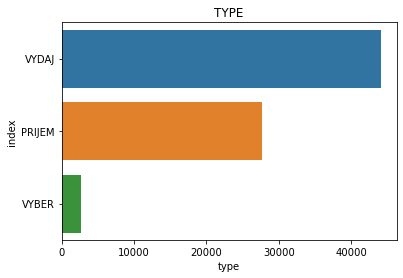

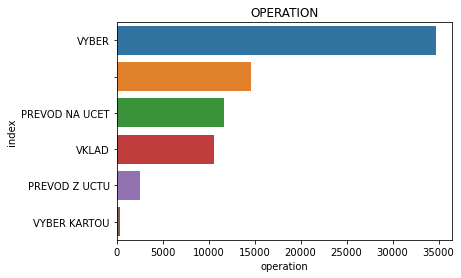

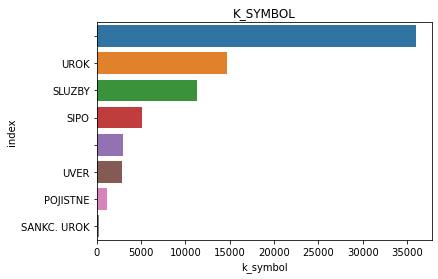

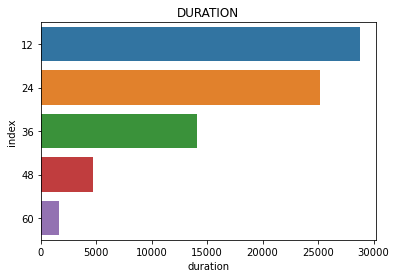

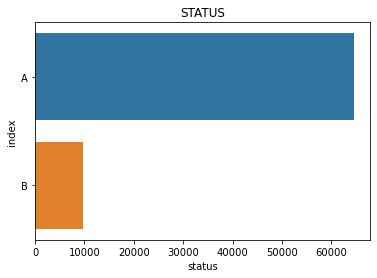

<Figure size 432x288 with 0 Axes>

In [21]:
## checking all the categorical columns
cols_cat = list(df.select_dtypes(include=['object']).columns)

for col in cols_cat:
    print("Frequency analysis of column: ",col)
    my_data = df[col].value_counts().reset_index()
    ax = sns.barplot(x=col, y="index", data = my_data).set_title(col.upper())
    plt.figure()
    print

### Clean and wrangling steps 

In [18]:
# change duration to object type 
#df['duration']=df['duration'].astype('str')
df['duration']=df['duration'].astype('object')

In [19]:
df.dtypes

type          object
operation     object
t_amount     float64
balance      float64
k_symbol      object
l_amount       int64
duration      object
payments     float64
status        object
dtype: object

In [25]:
df['k_symbol'].value_counts()

unknown        38971
UROK           14646
SLUZBY         11306
SIPO            5081
UVER            2893
POJISTNE        1159
SANKC. UROK      308
Name: k_symbol, dtype: int64

In [24]:
def cleankSymbol(x):
    if x in ['', ' ']:
        return 'unknown'
    else:
        return x

df['k_symbol'] = list(map(cleankSymbol, df['k_symbol']))

In [29]:
df['operation'].value_counts()

vyber      35057
unknown    14646
prevod     14136
vklad      10525
Name: operation, dtype: int64

In [28]:
def cleanOperation(x):
    x = x.lower()
    if 'vyber' in x:
        return "vyber"
    elif 'prevod' in x:
        return "prevod"
    elif 'vklad' in x:
        return 'vklad'
    else:
        return 'unknown'

df['operation'] = list(map(cleanOperation, df['operation']))

### pre processing 

In [31]:
# label / encode any categorical columns 

cat = df.select_dtypes(include = np.object)
cat

,type,operation,k_symbol,duration,status
0,PRIJEM,prevod,unknown,24,A
1,PRIJEM,vklad,unknown,12,A
2,PRIJEM,vklad,unknown,36,A
3,PRIJEM,vklad,unknown,12,A
4,PRIJEM,vklad,unknown,12,A
...,...,...,...,...,...
74359,PRIJEM,unknown,UROK,36,A
74360,PRIJEM,unknown,UROK,24,B
74361,PRIJEM,unknown,UROK,36,A
74362,PRIJEM,unknown,UROK,60,A


In [35]:
categorical=pd.get_dummies(cat, columns =['type', 'operation','k_symbol','duration', 'status'],drop_first=True)
categorical.head()
# could choose or not choose to drop first column 

,type_VYBER,type_VYDAJ,operation_unknown,operation_vklad,operation_vyber,k_symbol_SANKC. UROK,k_symbol_SIPO,k_symbol_SLUZBY,k_symbol_UROK,k_symbol_UVER,k_symbol_unknown,duration_24,duration_36,duration_48,duration_60,status_B
0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
3,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [36]:
categorical['status_B'].value_counts()

0    64599
1     9765
Name: status_B, dtype: int64

In [37]:
# numerical scaling 

from sklearn.preprocessing import Normalizer

In [39]:
X = df.select_dtypes(include=np.number)
transformer = Normalizer().fit(X)
X_normalised= transformer.transform(X)
X_normalised = pd.DataFrame(X_normalised)

### split off the dependant variable (label)

In [40]:
#sort out the categoricals 
y= categorical['status_B']
categorical=categorical.drop(['status_B'], axis=1)
categorical

,type_VYBER,type_VYDAJ,operation_unknown,operation_vklad,operation_vyber,k_symbol_SANKC. UROK,k_symbol_SIPO,k_symbol_SLUZBY,k_symbol_UROK,k_symbol_UVER,k_symbol_unknown,duration_24,duration_36,duration_48,duration_60
0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
3,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74359,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
74360,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
74361,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
74362,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


In [42]:
# bring the numerical data (scaled)in with the x cat
X = np.concatenate((X_normalised, categorical),axis=1)

### tt split, get model

In [45]:
from sklearn.linear_model import LogisticRegression

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =train_test_split(X, y, test_size= 0.4, random_state=40)

## apply model and train model 

In [47]:
classification = LogisticRegression(random_state=0, solver='lbfgs',max_iter=400,
                  multi_class='ovr').fit(X_train, y_train)

### evaluate accuracy and test 

In [48]:
from sklearn.metrics import accuracy_score 
predictions = classification.predict(X_test)

In [49]:
predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [50]:
accuracy_score(y_test, predictions)

0.87591608955826

In [ ]:
# next steps would be to visualise the accuracy of the predictions in some ways 

# can i improve my model ?? 